In [1]:
import pydicom
import matplotlib.pyplot as plt

import sigpy.plot as pl
%matplotlib notebook
import subtle.utils.io as suio
from glob import glob
import numpy as np
import nibabel as nib

# plt.set_cmap('gray')
# plt.rcParams['figure.figsize'] = (12, 10)

from skimage.morphology import binary_erosion, cube

/home/srivathsa/projects/SubtleGad/train/subtle/utils/hyperparameter.py:8: UserWarning: Module test_tube not found - hyperparameter related functions cannot be used
  warnings.warn('Module test_tube not found - hyperparameter related functions cannot be used')
/home/srivathsa/miniconda3/envs/py35gad/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [3]:
def get_dicom_vol(dirpath_dicom):
    dcm_files = sorted([f for f in glob('{}/*.dcm'.format(dirpath_dicom))])
    return np.array([pydicom.dcmread(f).pixel_array for f in dcm_files])

In [15]:
vol = get_dicom_vol('/home/srivathsa/projects/studies/gad/all/data/da20a7_81f793/Patient_0400/Patient_0400_SubtleGad')
# vol = get_dicom_vol('/home/srivathsa/projects/mrm_img_review/101_Id_066/SAG_MPRAGE_WE_POST_14_RFM')
# vol = vol.transpose(1, 0, 2)
print(vol.shape)

(160, 512, 512)


<IPython.core.display.Javascript object>


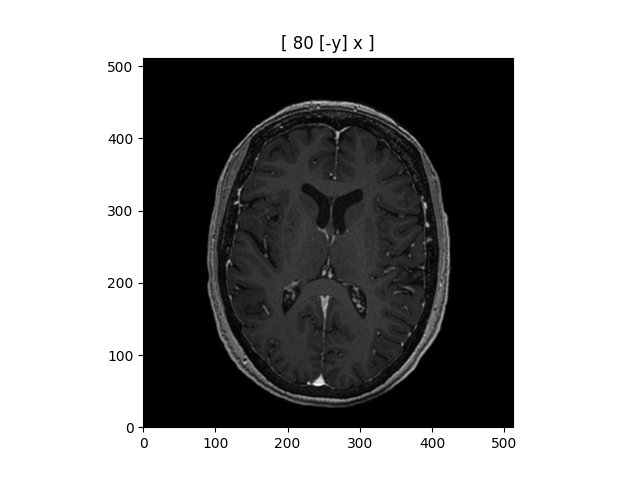

In [16]:
pl.ImagePlot(vol)

In [ ]:
y_inp = np.load('/home/srivathsa/projects/studies/gad/all/preprocess/data/NO31.npy')
print(y_inp.shape)

In [ ]:
y_pred = np.load('/home/srivathsa/projects/studies/gad/all/inference/y_pred.npy')
print(y_pred.shape)

In [ ]:
pl.ImagePlot(y_pred[..., 0])

In [ ]:
y_pred = np.load('/home/srivathsa/projects/studies/gad/all/inference/y_pred.npy')
print(y_pred.shape)
print(y_pred.dtype, y_pred.min(), y_pred.max())

In [ ]:
plt.imshow(y_pred[96, ..., 0])

In [25]:
data = suio.load_file('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/NO57.h5', params={'h5_key': 'all'})
uad = np.load('/home/srivathsa/projects/studies/gad/tiantan/preprocess/uad_masks/NO57.npy')

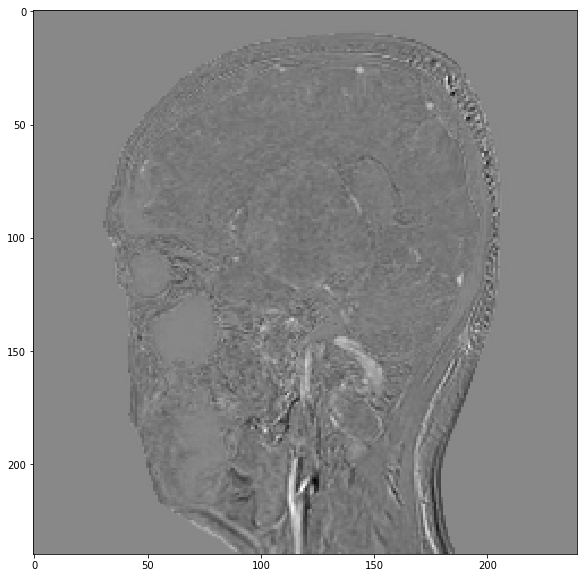

In [26]:
dz = data[0, :, 0]
dl = data[0, :, 1]
diff = dl-dz
plt.imshow(diff[122])

In [43]:
uad_mask = (uad >= (uad.max() * 0.1))
uad_mask = binary_erosion(uad_mask, selem=cube(7))
uad_mod = uad * uad_mask
dl_mod = dl + uad

mask = (data[1, :, 1] > 0.1)
dl_mod_mask = mask * dl_mod

In [44]:
data_mod = data.copy()
data_mod[0, :, 1] = dl_mod
data_mod[1, :, 1] = dl_mod_mask

In [46]:
suio.save_data_h5('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/NO57_mod.h5', 
                  data=data_mod[0], data_mask=data_mod[1])

0

<IPython.core.display.Javascript object>


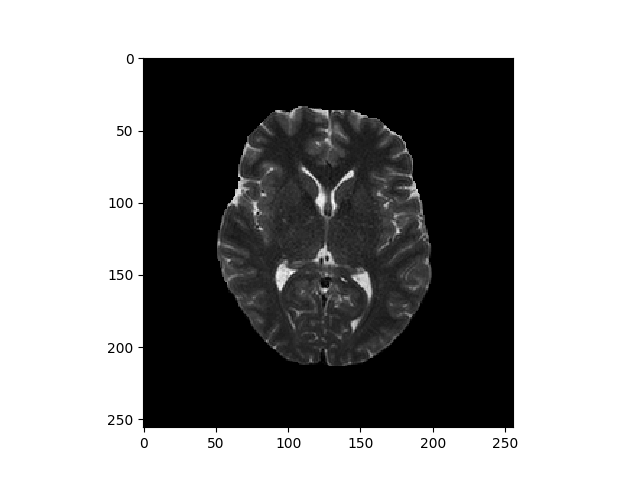

In [62]:
ixi_data = nib.load('/mnt/datasets/srivathsa/ixi/normal/IXI020-Guys-0700-T2.nii.gz').get_data()
sl = 60
disp = np.rot90(ixi_data[..., sl])
plt.imshow(disp)

In [8]:
data = np.load('/home/srivathsa/projects/studies/gad/all/preprocess/data/Patient_0400.npy')

In [9]:
data.shape

(2, 320, 3, 512, 512)

In [13]:
meta = suio.load_h5_metadata('/home/srivathsa/projects/studies/gad/all/preprocess/data/Patient_0400_meta.h5')

In [14]:
meta['zero_pad_size']

array([512, 512])